In [1]:
from __future__ import division
import configparser
import codecs
import json
import csv
import random
from textwrap import fill
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

In [2]:
config = configparser.ConfigParser()
my_config = '../Config/default.cfg'
with open(my_config, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')

sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
from utils import print_timestamped_message

sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational

sys.path.append('../../sempix-master/Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [3]:
# Load up preprocessed DataFrames
df_names = [
            'saiapr_bbdf',
            'mscoco_bbdf'
           ]
df = load_dfs(preproc_path, df_names)

df['saiapr_bbdf'].head()

,i_corpus,image_id,region_id,bb,cat
0,0,112,1,"[76, 50, 371, 308]",120
1,0,112,2,"[0, 260, 89, 96]",204
2,0,112,3,"[390, 206, 89, 151]",204
3,0,112,4,"[0, 0, 156, 191]",29
4,0,112,5,"[374, 0, 104, 165]",29


## SAIAPR TC-12: Holiday Pictures

IAPR TC-12 is a collection of  “20,000 still natural images taken from locations around the world and comprising an assorted cross-section of still natural images” \cite{Grubinger2006}. This dataset was later augmented by \cite{Escalante2010} with segmentation masks identifying objects in the images (an average of 5 objects per image). It was further augmented by \cite{Kazemzadeh2014} with expressions referring to objects in the images. (This annotation will be discussed elsewhere.)

Here's an example of an object-annotated image from the corpus. (Note that the corpus actually provides segmentation masks, which are tight boundaries around the objects. For simplicity, and since most modern methods actually take rectangular image patches as input, this is extended in our preprocessing to the smallest box that contains all pixels.) 

In [4]:
# Load mapping from category ID to category name
saiapr_cat_path = os.path.join(config.get('SAIAPR', 'saiapr_base'),
                               'SAIA_Data/benchmark/wlist.txt')

saiapr_cat = {}
with open(saiapr_cat_path, 'r') as f:
    csv_reader = csv.reader(f, delimiter='\t')
    for row in csv_reader:
        saiapr_cat[int(row[0])] = row[1]

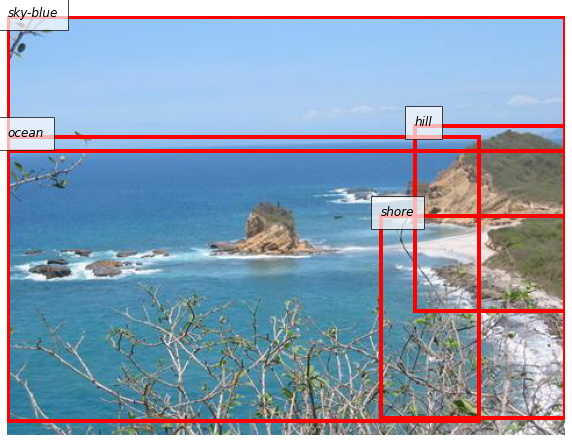

In [7]:
# Plot one image from the corpus, together with bounding boxes around segmented objects.
ii = 5001
ic = icorpus_code['saiapr']
bbs = [(bb, saiapr_cat[cat_id]) 
       for bb, cat_id in query_by_id(df['saiapr_bbdf'], (ic, ii), ['bb', 'cat']).values]
plot_labelled_bb(get_image_filename(config, ic, ii), bbs)

As the following random sample likely shows, this image corpus is representative of the kinds of images a tourist might take on a trip. As such, it is perhaps less representative of the kinds of surroundings one finds oneself in or things one sees most often.

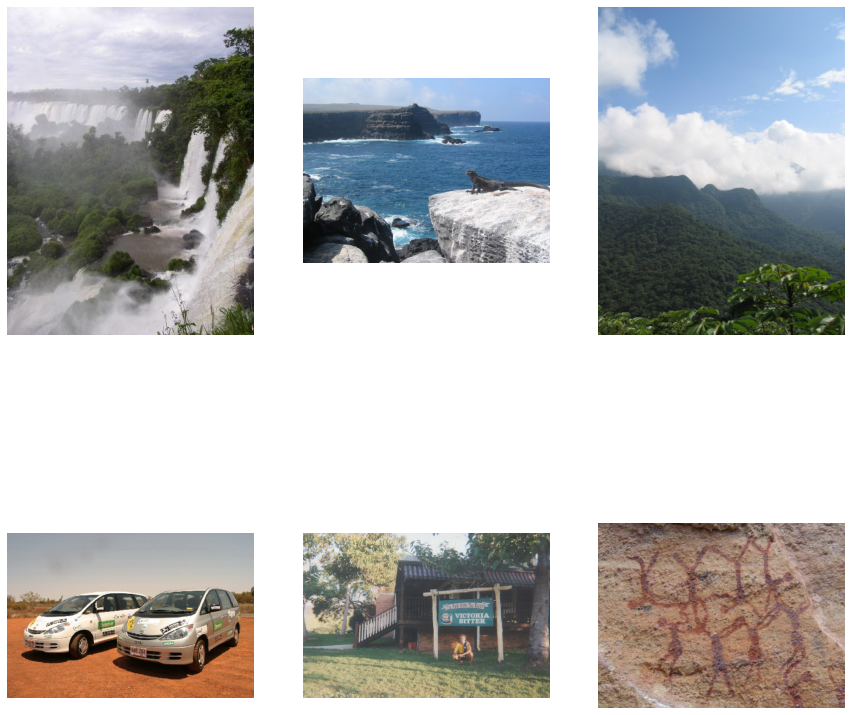

In [8]:
# A random sample of 6 images from SAIAPR
all_iis = df['saiapr_bbdf']['image_id'].unique()
n_rows = 2
n_cols = 3

_, ax = plt.subplots(n_rows, n_cols, figsize=(15, 15))

for n in range(n_rows):
    for m in range(n_cols):
        ii = np.random.choice(all_iis)
        plot_img_ax(config, ax[n,m], 'saiapr', ii)